<a href="https://colab.research.google.com/github/vipul43/image_description/blob/main/MutliModalClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# installs

In [2]:
# imports
import scipy.io
import cv2
from google.colab.patches import cv2_imshow
from skimage import io
import numpy as np
import pandas as pd
from PIL import Image 
import matplotlib.pylab as plt
import pickle
from skimage import transform
from sklearn.model_selection import train_test_split
import tensorflow as tf
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, LancasterStemmer
import spacy
import nltk
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [3]:
nltk.download('punkt') #tokenizer
nltk.download('wordnet') #lemmatization

lemmatizer = WordNetLemmatizer() #lemmatizer

sp = spacy.load('en_core_web_sm') #lexical importance find

ls = LancasterStemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
# data loading

!gdown --id 1mrjvJq6XNM8QAgajSgrVGpsj8Vrm3BEm #PASCAL50S

mat = scipy.io.loadmat('/content/pascal50S.mat')
print(type(mat))

Downloading...
From: https://drive.google.com/uc?id=1mrjvJq6XNM8QAgajSgrVGpsj8Vrm3BEm
To: /content/pascal50S.mat
100% 1.12M/1.12M [00:00<00:00, 17.6MB/s]
<class 'dict'>


In [5]:
classes = ['person',
           'bird', 
           'cat', 
           'cow', 
           'dog', 
           'horse', 
           'sheep', 
           'aeroplane', 
           'bicycle', 
           'boat', 
           'bus', 
           'car', 
           'motorbike', 
           'train', 
           'bottle', 
           'chair', 
           'dining table', 
           'potted plant',
           'sofa', 
           'tv'] #NOUNS

dict_classes = {'person':0, 'man':0, 'human':0,
           'bird':1, 'penguin':1, 'parrot':1, 'sparrow':1,
           'cat':2, 
           'cow':3, 
           'dog':4, 
           'horse':5,
           'sheep':6, 
           'aeroplane':7, 'airplane':7, 'flight':7, 'plane':7, 'jet':7,
           'bicycle':8, 'cycle':8,
           'boat':9, 'ship':9,
           'bus':10, 
           'car':11,
           'motorbike':12, 'bike':12, 'motorcycle':12,
           'train':13, 
           'bottle':14, 'waterbottle':14, 'drinkbottle':14, 'flask':14,
           'chair':15,
           'dining':16, 'diningtable': 16,
           'potted':17, 'plant':17, 'pottedplant': 17,
           'sofa':18, 'couch':18,
           'tv':19, 'monitor':19, 'television':19, 'desktop':19}

In [6]:
count = {'0':0,   #person
           '1':0, #bird
           '2':0, #cat
           '3':0, #cow
           '4':0, #dog
           '5':0, #horse
           '6':0, #sheep
           '7':0, #aeroplane
           '8':0, #bicycle
           '9':0, #boat
           '10':0, #bus
           '11':0, #car
           '12':0, #motorbike
           '13':0, #train
           '14':0, #bottle
           '15':0, #chair
           '16':0, #dining
           '17':0, #potted plant
           '18':0, #sofa
           '19':0} #tv/monitor

In [7]:
# observing data
data = []
idx=0
for sample in mat["train_sent_final"][0]:
  # image = io.imread(i[0][0])
  # cv2_imshow(image)
  link = [sample[0][0]] #image link
  cls = set()
  for k in sample[1]:
    for sent in k:
      # if idx==10:
      #   break
      # idx+=1

      for word in sent[0].split():
        pre_word = lemmatizer.lemmatize(ls.stem(word.lower()))
        if(pre_word in dict_classes.keys()):
          cls.add(dict_classes[pre_word])
  for cl in cls:
    count[str(cl)]+=1
  data.append([link, list(cls)])

In [8]:
file = open("data.pkl", "wb")
pickle.dump(data, file)
file.close()

In [25]:
# preprocessing the dataset
'''
data -> url -> image -> array -> resized array
TrainX = array of images resized to (224x224x3)
TrainY = array of labels with size (20x1) in ones-zeros vector like [1, 1, 0, ....]
'''
# TrainX
new_shape = (224, 224, 3)
TrainX1 = []
encoded_train_images = {}

base_model = tf.keras.applications.Xception(include_top = False)
for point in data:
  photo = io.imread(point[0][0])
  photo = transform.resize(image=photo, output_shape=new_shape)
  TrainX1.append(photo)

  batch_photo = np.expand_dims(photo, axis=0)
  preproc_photo = tf.keras.applications.xception.preprocess_input(batch_photo)
  vec_repre_photo = base_model.predict(preproc_photo)
  # vec_repre_photo = np.reshape(vec_repre_photo, vec_repre_photo.shape[1])
  encoded_train_images[point[0][0]] = vec_repre_photo

TrainX1 = np.array(TrainX1)

In [26]:
# TrainY
TrainY = []
for points in data:
  full_label = np.zeros(shape=(20, ))
  for label in points[1]:
    full_label[label] = 1
  TrainY.append(full_label)
TrainY = np.array(TrainY)

In [27]:
with open("encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoded_train_images, encoded_pickle)

**Extracting the data from pkl file**

In [28]:
# with open('encoded_train_images.pkl', 'rb') as f:
#     data = pickle.load(f)

In [13]:
# # data splitting
# '''
# train size: 700 images
# val size: 300 images
# output: TrainX, TrainY, ValX, ValY
# '''
# TrainX, ValX, TrainY, ValY = train_test_split(TrainX, TrainY, test_size=0.3, random_state=1)
# print("Train X shape: ", TrainX.shape)
# print("Train Y shape: ", TrainY.shape)
# print("Val X shape: ", ValX.shape)
# print("Val Y shape: ", ValY.shape)

Train X shape:  (700, 224, 224, 3)
Train Y shape:  (700, 20)
Val X shape:  (300, 224, 224, 3)
Val Y shape:  (300, 20)


In [14]:
# instantiate data augmentation
'''
use this 'tf.keras.preprocessing.ImageDataGenerator'
'''
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                          shear_range=0.2, 
                                                          zoom_range=0.2,
                                                          rotation_range=15,
                                                          horizontal_flip=True)

In [16]:
# model making(Image to Vector)
# input layer
input1 = tf.keras.Input(shape=(224, 224, 3), name='input1')

# Transfer Learning with VGG16 model with weights as imagenet
vgg16 = tf.keras.applications.VGG16(include_top=False, weights="imagenet", classes=20)
vgg16.trainable = False
x = vgg16(input1)

# Dense Layers
x = tf.keras.layers.Flatten(name='flatten')(x)
x = tf.keras.layers.BatchNormalization(name='norm1')(x)
x = tf.keras.layers.Dense(192, activation='relu', name='dense1')(x)
x = tf.keras.layers.BatchNormalization(name='norm2')(x)
x = tf.keras.layers.Dense(84, activation='relu', name='dense2')(x)
x = tf.keras.layers.BatchNormalization(name='norm3')(x)
x = tf.keras.layers.Dense(64, activation='relu', name='dense3')(x)
x = tf.keras.layers.BatchNormalization(name='norm4')(x)

#Output layer
output = tf.keras.layers.Dense(500, activation="linear", name='output')(x)

model1 = tf.keras.models.Model(inputs=input1, outputs=output, name='model1')

model1.summary()

Model: "model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input1 (InputLayer)          [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
norm1 (BatchNormalization)   (None, 25088)             100352    
_________________________________________________________________
dense1 (Dense)               (None, 192)               4817088   
_________________________________________________________________
norm2 (BatchNormalization)   (None, 192)               768       
_________________________________________________________________
dense2 (Dense)               (None, 84)                16212

**Text Model(Model2)**

#**Data Preprocessing**

In [17]:
# observing data for text Model
data2 = []
stringX2 = []
idx=0
for sample in mat["train_sent_final"][0]:
  # image = io.imread(i[0][0])
  # cv2_imshow(image)
  link = [sample[0][0]] #image link
  cls = set()
  for k in sample[1]:
    for sent in k:
      # if idx==10:
      #   break
      # idx+=1

      for word in sent[0].split():
        pre_word = lemmatizer.lemmatize(ls.stem(word.lower()))
        if(pre_word in dict_classes.keys()):
          cls.add(dict_classes[pre_word])
  for cl in cls:
    count[str(cl)]+=1

  for k in sample[1]:
    for sent in k:
      stringX2.append(sent[0])
      temp = np.zeros(shape=20)
      for ele in list(cls):
        temp[ele] = 1
      data2.append([sent, temp])

In [18]:
#Preparation of TrainX2 and Trainy2 for Text Model(Model2)
tk = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\]^`{|}~\t\n')
tk.fit_on_texts(stringX2)
X_seq = tk.texts_to_sequences(stringX2)
X_pad = pad_sequences(X_seq, maxlen=100, padding='post')
X_pad.shape
TrainX2 = X_pad
Trainy2 = np.zeros(shape=(len(data2), 20))
i = 0
for d in data2:
  Trainy2[i] = np.array(d[1])
  i = i + 1

In [20]:
INP_LEN1 = 100 #(Text to Vector)
input2 = tf.keras.Input(shape=(INP_LEN1,), name='input')
embed = tf.keras.layers.Embedding((len(tk.word_counts)+1),INP_LEN1)(input2)
rnn1 = tf.keras.layers.SimpleRNN(192, return_sequences=True, dropout=0.3)(embed)
pool = tf.keras.layers.MaxPool1D()(rnn1)
rnn2 = tf.keras.layers.SimpleRNN(128, dropout=0.2)(pool)
dense1 = tf.keras.layers.Dense(84, activation='relu')(rnn2)
drop1 = tf.keras.layers.Dropout(0.2)(dense1)
norm1 = tf.keras.layers.BatchNormalization()(drop1)
output = tf.keras.layers.Dense(500, activation='linear')(norm1)

model2 = tf.keras.models.Model(inputs=input2, outputs=output, name='model2')
model2.summary()


Model: "model2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 100)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          758600    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 100, 192)          56256     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 192)           0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 128)               41088     
_________________________________________________________________
dense_2 (Dense)              (None, 84)                10836     
_________________________________________________________________
dropout_1 (Dropout)          (None, 84)                0    

**Concatenating the Image Model(Model1) and Text Model(Model2)**

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, None, None, 5 14714688    input1[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 25088)        0           vgg16[0][0]                      
__________________________________________________________________________________________________
input (InputLayer)              [(None, 100)]        0                                            
____________________________________________________________________________________________

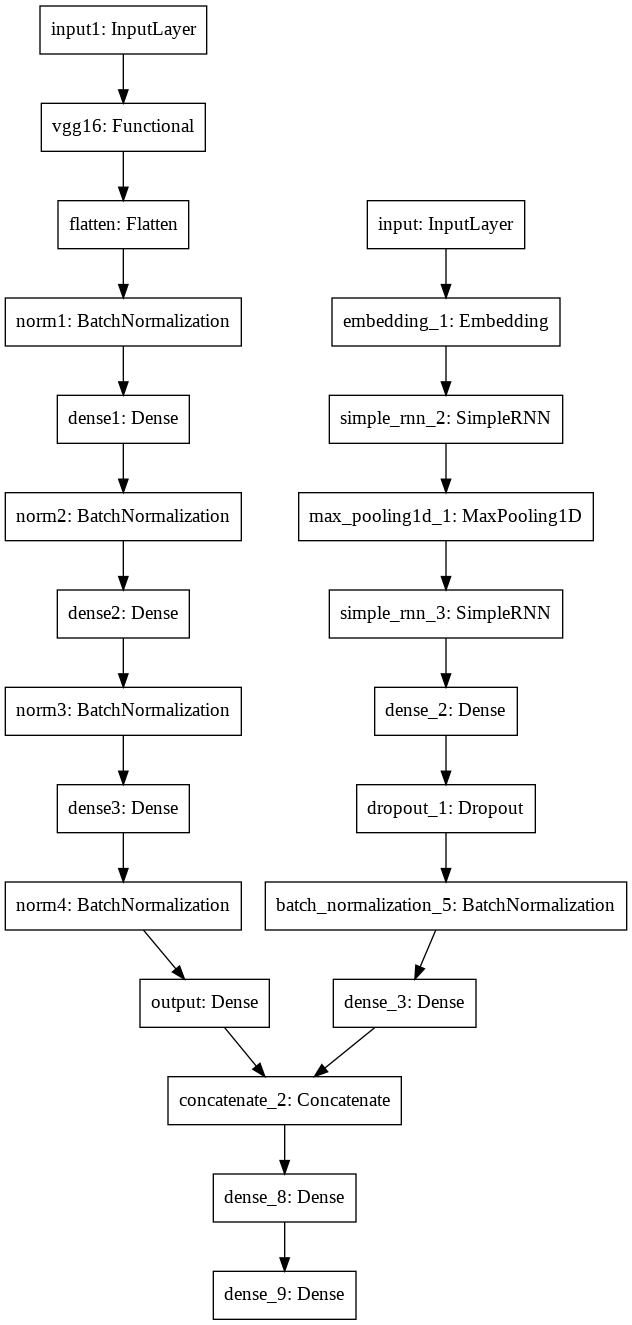

In [53]:
concate = tf.keras.layers.Concatenate(axis=-1)([model1.output, model2.output])
final_dense = tf.keras.layers.Dense(256, activation='relu')(concate)
Output = tf.keras.layers.Dense(20, activation='sigmoid')(final_dense)
finalModel  = tf.keras.models.Model(inputs=[input1,input2],outputs=Output)

finalModel.summary()
tf.keras.utils.plot_model(finalModel,to_file="finalModel.png")

**Train the MultiModal**

In [54]:
finalModel.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [55]:
finalModel.fit([TrainX1, TrainX2], TrainY, validation_split=0.2, shuffle=True, epochs=10)

Epoch 1/10
25/25 [==============================] - 9s 255ms/step - loss: 3.7337 - accuracy: 0.0494 - val_loss: 0.4921 - val_accuracy: 0.4650
Epoch 2/10
25/25 [==============================] - 6s 227ms/step - loss: 0.5018 - accuracy: 0.3157 - val_loss: 0.3525 - val_accuracy: 0.1950
Epoch 3/10
25/25 [==============================] - 6s 230ms/step - loss: 0.3091 - accuracy: 0.2838 - val_loss: 0.2585 - val_accuracy: 0.3850
Epoch 4/10
25/25 [==============================] - 6s 232ms/step - loss: 0.2561 - accuracy: 0.3330 - val_loss: 0.2384 - val_accuracy: 0.3150
Epoch 5/10
25/25 [==============================] - 6s 230ms/step - loss: 0.2460 - accuracy: 0.3100 - val_loss: 0.2351 - val_accuracy: 0.3700
Epoch 6/10
25/25 [==============================] - 6s 230ms/step - loss: 0.2350 - accuracy: 0.3161 - val_loss: 0.2325 - val_accuracy: 0.3450
Epoch 7/10
25/25 [==============================] - 6s 232ms/step - loss: 0.2237 - accuracy: 0.3405 - val_loss: 0.2322 - val_accuracy: 0.4600
Epoch 

**Predictions**

In [72]:
i = np.random.randint(0,len(TrainX1))
sampleX1 = np.expand_dims(TrainX1[i], axis=0)
sampleX2 = np.expand_dims(TrainX2[i], axis=0)

pred_y = finalModel.predict([sampleX1, sampleX2])
true_y = TrainY[i]
y = (pred_y > 0.15).astype(int)
print(pred_y)
print(y)
print(true_y)

[[3.37972611e-01 1.11532453e-02 1.80101022e-01 1.46467984e-01
  7.31153414e-02 7.32035187e-05 4.12042104e-02 1.20361047e-02
  1.82980546e-08 2.33566761e-02 1.05954818e-01 4.77134958e-02
  1.04826577e-04 1.68883950e-02 1.34494998e-10 1.06132992e-01
  1.82005488e-09 1.08943425e-01 1.13411117e-02 3.36855575e-02]]
[[1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# # config cell
# LR = 0.0009
# EPOCHS = 20
# BATCH_SIZE = 16
# DECAY = LR // EPOCHS
# LOSS = tf.keras.losses.BinaryCrossentropy()
# OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR, decay=DECAY)
# METRICS = ['acc']

In [ ]:
# model compiling
# model1.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)

In [ ]:
# training
# history = model1.fit(datagen.flow(TrainX, TrainY, batch_size=BATCH_SIZE), validation_data=datagen.flow(ValX, ValY, batch_size=BATCH_SIZE), epochs=EPOCHS)

Epoch 1/20
44/44 [==============================] - 12s 255ms/step - loss: 0.1644 - acc: 0.3155 - val_loss: 0.2295 - val_acc: 0.0967
Epoch 2/20
44/44 [==============================] - 11s 243ms/step - loss: 0.1580 - acc: 0.3200 - val_loss: 0.2061 - val_acc: 0.3333
Epoch 3/20
44/44 [==============================] - 11s 248ms/step - loss: 0.1513 - acc: 0.3470 - val_loss: 0.2030 - val_acc: 0.1600
Epoch 4/20
44/44 [==============================] - 11s 247ms/step - loss: 0.1506 - acc: 0.3657 - val_loss: 0.2180 - val_acc: 0.1867
Epoch 5/20
44/44 [==============================] - 11s 241ms/step - loss: 0.1456 - acc: 0.3548 - val_loss: 0.1985 - val_acc: 0.1900
Epoch 6/20
44/44 [==============================] - 11s 242ms/step - loss: 0.1427 - acc: 0.3658 - val_loss: 0.1987 - val_acc: 0.2367
Epoch 7/20
44/44 [==============================] - 11s 243ms/step - loss: 0.1504 - acc: 0.3499 - val_loss: 0.2022 - val_acc: 0.2267
Epoch 8/20
44/44 [==============================] - 11s 242ms/step - 

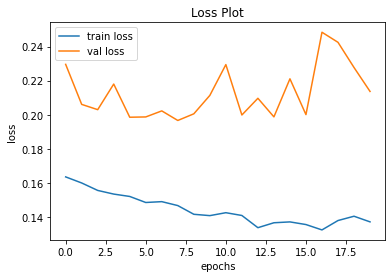

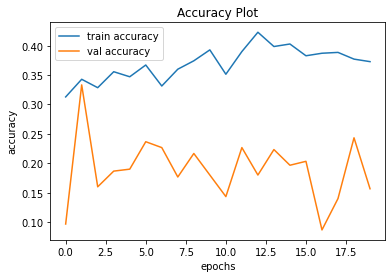

In [ ]:
# plotting curves
'''
loss -> train, val
accuracy -> train, val
'''
plt.plot(list(history.history.values())[0])
plt.plot(list(history.history.values())[2])
plt.title('Loss Plot')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train loss', 'val loss'])
plt.show()

plt.plot(list(history.history.values())[1])
plt.plot(list(history.history.values())[3])
plt.title('Accuracy Plot')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train accuracy', 'val accuracy'])
plt.show()

In [ ]:
# random predictions on val dataset

rnd = np.random.randint(0, len(ValX))
point = ValX[rnd]
label = ValY[rnd]
pred = model.predict(np.asarray([point]))
pred = (pred > 0.5)
pred = pred.astype(int)
print("True Label:", label)
print("Predicted Label:", pred)

True Label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Predicted Label: [[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
